In [1]:
import os
import timm
import torch
import numpy as np
import pandas as pd

from torch import nn
from tqdm import tqdm
from skimage import io
from random import sample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

In [2]:
# classe per caricare il modello di rete neurale 
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [3]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, fake_data_dir, real_data_dir, device):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):
      if "real" in str(i):
        dir_folder = real_data_dir
      else: 
        dir_folder = fake_data_dir

      a = io.imread(os.path.join(dir_folder, i))
      a = np.expand_dims(a, 0)
      a = torch.from_numpy(a.astype(np.int32)) / 255.0
      a = a.to(device)
      
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    anc_img_names_df = pd.DataFrame(anc_img_names_arr, columns=['Anchor'])
    df_enc = pd.concat([anc_img_names_df, encodings], axis=1)

    return df_enc

In [4]:
# funzione che genera embeddings di una singola immagine
def get_image_embeddings(img, model, device):
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [5]:
# distanza euclidea per array np
def array_distance(img_enc, anc_enc_arr):
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)

    return dist

In [6]:
# funzione che cerca nel database l'immagine più simile a quella data in input
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = array_distance(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [7]:
# funzione per ottenere i path di tutti i file in una cartella (per creare dataset di test)
def get_file_paths(directory): 
    file_paths = []

    for root, _, files in os.walk(directory):
        for file in files:
            # path completo del file
            file_path = os.path.join(root, file)  
            file_paths.append(file_path)
            
    return file_paths

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# configurazione
device="cuda"

# stringhe usate nella funzione di testing, devono avere il nome uguale ai file delle immagini presenti nel database degli encodings
# es. anchor="d:\\folder\img_fake_01.png" fake_dataset="fake"
# es. anchor="d:\\folder\img_coco_01.png" real_dataset="coco"
fake_dataset = "fake"
real_dataset = "real"

In [10]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device);

In [11]:
# per ricaricare il modello già allenato e il dataset di encoding (che servirà per il testing)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [12]:
# directory da dove vengono prelevate le immagini per il testing e per creare il dataset di encodings
fake_data_dir = "D:\\sviluppo\\project-detective\\temp\\taming_transformer+coco\\test\\taming_transformer"
real_data_dir = "D:\\sviluppo\\project-detective\\temp\\taming_transformer+coco\\test\\coco"

In [13]:
# su quante immagini per ogni classe si deve fare il test
test_size = 1000

# si prelevano le immagini per fare il test
fake_images = get_file_paths(fake_data_dir)
real_images = get_file_paths(real_data_dir)

fake_images = sample(fake_images, test_size)
real_images = sample(real_images, test_size * 2)

In [14]:
# cartelle dove prelevare le immagini del dataset di training 
fake_df_out_dir = os.path.join("..", "temp", "taming_transformer+coco", "train", "taming_transformer")
real_df_out_dir = os.path.join("..", "temp", "taming_transformer+coco", "train", "coco")

# si usa il dataset di training per creare il dataset di encodings che serve per il testing
df_out_path = os.path.join("..", "datasets", "fourier_out.csv")
df_out = pd.read_csv(df_out_path)

In [15]:
# si creano gli embeddings che vengono memorizzati 
if not os.path.isfile("database.csv"):
    df_enc = get_encoding_csv(model, df_out["Anchor"], fake_df_out_dir, real_df_out_dir, device)
    df_enc.to_csv("database.csv", index=False)
else: 
    df_enc = pd.read_csv("database.csv")

In [16]:
y_true = []
y_pred = []

In [17]:
# testo i fake
for i in tqdm(fake_images, desc="testing on fake images..."):
    path = i

    # si legge l'immagine
    img = io.imread(path)
    # si ottiene il vettore di embeddings dell'immagine
    img_enc = get_image_embeddings(img, model, device)
    # si cerca nel dataset con gli encodings un'immagine simile 
    closest_label = search_in_database(img_enc, df_enc)
    
    # se nel path dell'immagine c'è il nome del dataset real è real
    if real_dataset in str(closest_label):
        y_pred.append("real")
    # viceversa
    else:
        y_pred.append("fake")

testing on fake images...: 100%|██████████| 1000/1000 [14:29<00:00,  1.15it/s]


In [18]:
# testo i real
for i in tqdm(real_images, desc="testing on real images..."):
    path = i

    img = io.imread(path)
    img_enc = get_image_embeddings(img, model, device)
    closest_label = search_in_database(img_enc, df_enc)

    if real_dataset in str(closest_label):
        y_pred.append("real")
    else:
        y_pred.append("fake")

testing on real images...: 100%|██████████| 2000/2000 [28:56<00:00,  1.15it/s]


In [19]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(fake_images))
temp = np.array(["real"] * len(real_images))
y_true = np.concatenate([y_true, temp])

# calcolo la matrice di confusione 
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

[[1695  305]
 [ 157  843]]


In [20]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 84.6, 'Precision': 73.42999999999999, 'Recall': 84.3, 'Specificity': 84.75, 'F1 Score': 78.4904}


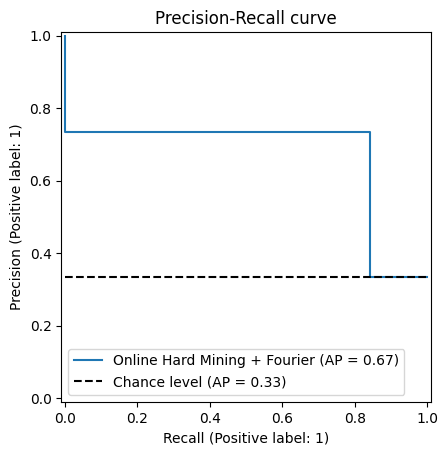

In [21]:
# si convertono ground truth e predizioni in binario per calcolare la precision-recall curve
y_pred_nd = np.array(y_pred)

y_true_binary = np.where(y_true == "real", 0, 1)
y_pred_binary = np.where(y_pred_nd == "real", 0, 1)

display = PrecisionRecallDisplay.from_predictions(
    y_true_binary, y_pred_binary, pos_label=1, name="Online Hard Mining + Fourier", plot_chance_level=True
)

display.ax_.set_title("Precision-Recall curve");